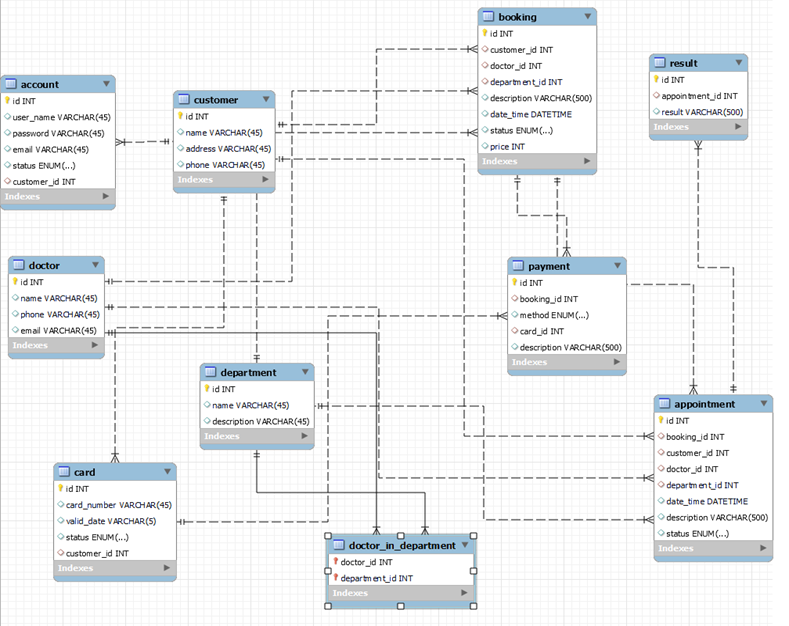

In [ ]:
sql = """
-- 1. Get Customer who have card in the system and show their cards.

SELECT
    cus.id, cus.name, c.card_number
FROM
    card c
        LEFT JOIN
    customer cus ON cus.id = c.customer_id
ORDER BY id;


-- 2. Get all customers who live in Ho Chi Minh City

SELECT
    cus.id, cus.name
FROM
    customer cus
WHERE
    cus.address LIKE '%HCM%';

-- 3. how many percentages of ACTIVE/INACTIVE account

SELECT
    status,
    (COUNT(*) * 100) / (SELECT
            COUNT(*)
        FROM
            account) AS percentage
FROM
    account
GROUP BY status;


-- 4. Show all Doctor with their skill/departments.

SELECT
    dr.id, dr.name, dep.name
FROM
    doctor dr
        LEFT JOIN
    doctor_in_department d ON dr.id = d.doctor_id
        LEFT JOIN
    department dep ON dep.id = d.department_id
ORDER BY dr.id DESC;

-- 5. order doctor has most skills/departments to least.

SELECT
    dr.id, dr.name, COUNT(d.department_id) AS total_skill
FROM
    doctor dr
        LEFT JOIN
    doctor_in_department d ON dr.id = d.doctor_id
GROUP BY dr.id
ORDER BY total_skill DESC;

-- 6. which departments does not have doctor?

SELECT
    dep.id ID,
    dep.name Department,
    COUNT(d.doctor_id) No_of_doctor
FROM
    department dep
        LEFT JOIN
    doctor_in_department d ON d.department_id = dep.id
GROUP BY ID
HAVING COUNT(d.doctor_id) = 0
ORDER BY ID DESC;

-- 7. which departments has most doctors? how many? which has the least? how many?

WITH Noofdoctor as(SELECT COUNT(d.doctor_id) n
                   FROM department dep
                   LEFT JOIN doctor_in_department d ON d.department_id = dep.id
                   GROUP BY dep.id)

SELECT
    dep.id ID,
    dep.name Department,
    COUNT(d.doctor_id) No_of_doctor
FROM
    department dep
        LEFT JOIN
    doctor_in_department d ON d.department_id = dep.id
GROUP BY ID
HAVING No_of_doctor = (SELECT
        MAX(n)
    FROM
        Noofdoctor)

UNION

SELECT
    dep.id ID,
    dep.name Department,
    COUNT(d.doctor_id) No_of_doctor
FROM
    department dep
        LEFT JOIN
    doctor_in_department d ON d.department_id = dep.id
GROUP BY ID
HAVING No_of_doctor = (SELECT
        MIN(n)
    FROM
        Noofdoctor)

-- 8. get total imcome each year

SELECT
    YEAR(b.date_time) Year, SUM(b.price) Income
FROM
    booking b
WHERE
    status = 'PAID'
GROUP BY Year
ORDER BY Year ASC;

-- 9. which department has the biggest average income for every appointment all the time?

SELECT
    dep.id, dep.name, AVG(b.price) average_income
FROM
    department dep
        LEFT JOIN
    booking b ON b.department_id = dep.id
GROUP BY dep.id
HAVING average_income = (SELECT
        MAX(a)
    FROM
        (SELECT
            department_id id, AVG(b.price) a
        FROM
            booking b
        GROUP BY id) avg_i);

-- 10. show the total sell in the last 12 months.

WITH price_per_month AS (SELECT
    DATE_FORMAT(date_time, '%y-%m') m, SUM(price) p
FROM
    booking
GROUP BY m
ORDER BY m DESC
LIMIT 12)

SELECT
    SUM(p) '12months_income'
FROM
    price_per_month

-- 11. in the last 5 months, which payment method has the most payment times. and how many percentages?

WITH payment_methods_per_month AS (SELECT
    DATE_FORMAT(date_time, '%y-%m') m, p.method method, count(p.method) count,
    RANK () OVER(ORDER BY DATE_FORMAT(date_time, '%y-%m') DESC) rnk
FROM
    booking b
LEFT JOIN
    payment p ON b.id = p.booking_id WHERE b.status = 'PAID'
GROUP BY m,p.method
ORDER BY m DESC
),
last_5_mth_payment_method AS (SELECT
    m, method, count
FROM
    payment_methodS_per_month
WHERE
    rnk < 6
),
count_and_percentage_of_paymentmethods AS (SELECT
    method,
    SUM(count) No_of_payment,
    SUM(count) * 100 / (SELECT
            SUM(count)
        FROM
            last_5_mth_payment_method) percentage,
	RANK() OVER(ORDER BY SUM(count) DESC) rnk
FROM
    last_5_mth_payment_method
GROUP BY method)

SELECT
    *
FROM
    count_and_percentage_of_paymentmethods
WHERE
    rnk = 1

-- 12. Show the total appointments that each doctor take part in

SELECT
    d.id, d.name, COUNT(a.id) no_of_appointment
FROM
    appointment a
        LEFT JOIN
    doctor d ON d.id = a.doctor_id
WHERE
    status = 'DONE'
GROUP BY d.id

-- 13. Show all information of an appointment of a customer (customer ID = 1)

SELECT
    *
FROM
    appointment
WHERE
    customer_id = 1

-- 14. Which card never pay?

SELECT
    cr.*, COUNT(IF(p.id is null, null, 1)) AS payment_time
FROM
    card cr
        LEFT JOIN
    payment p ON cr.id = p.card_id
GROUP BY cr.id
HAVING payment_time = 0

-- 15. Show money paid of each card.

SELECT
    cr.id,
    cr.card_number,
    SUM(IF(price IS NULL, 0, price)) amount_paid
FROM
    card cr
        LEFT JOIN
    payment p ON cr.id = p.card_id
        LEFT JOIN
    booking b ON b.id = p.booking_id
GROUP BY cr.id

-- 16. Which doctor cannot use their skill?

SELECT
    dr.id,
    dr.name,
    COUNT(IF(a.id IS NULL, NULL, 1)) total_appointment
FROM
    doctor dr
        LEFT JOIN
    booking b ON dr.id = b.doctor_id
        LEFT JOIN
    appointment a ON b.id = a.booking_id
        AND a.status = 'DONE'
GROUP BY dr.id
HAVING total_appointment = 0

"""